## IBM Applied Data Science Capstone Project

## The Battle of the Neighborhoods Part 2

<em><strong> Setting up a Coffee Shop in Mumbai-Maharashtra(India)</strong></em>

## Introduction

The aim of the project is to find a suitable neighborhood in the city of Mumbai to set up a coffee shop. Starting a new business requires a lot of planning and deciding the location is one major aspect. It is advisable to look out for the competition. Apart from the competition, one also needs to check the neighborhood of target location. A location having bookstores, shops and movie theaters is more likely to attract customers. These two factors will be considered inthis project to suggest possible locations. 

## Data

I have used dataset from Wikipedia to get the neighborhoods of Mumbai. I also found the location coordiantes in that database. For listing venues, I have used Foursquare API data. 

## Methodology

<ol>
    <li>Scrape the data from web and extract it into a dataframe after cleaning.</li>
    <li>Get the co-ordinates of Mumbai and plot the map using Folium</li>
    <li>Use the Foursquare API to get the venues.</li>
    <li>Create the competition and favorable venues parameters</li>
    <li>Perform the clustering</li>
    <li>Examine clusters to find out suitable neighborhoods.</li>
</ol>

<strong>Importing Libraries</strong>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
!conda install html5lib --yes
!pip install lxml
!pip install bs4
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates     pkgs/main::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               pkgs/main::certifi-2020.6.20-py36_0 --> conda-forge::certifi-2020.6.20-py36h9f0ad1d_0
  openssl              pkgs/main::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - html5lib


The following packages will be downloaded:

    package                    |            build
    -------

## Scraping data from the web

In [2]:
url='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'

response=requests.get(url)

html = response.text

page = BeautifulSoup(html,'html.parser')

print(page)


<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of neighbourhoods in Mumbai - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"83d6ff1c-cc32-4a3d-8897-8f09c9f6439b","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_neighbourhoods_in_Mumbai","wgTitle":"List of neighbourhoods in Mumbai","wgCurRevisionId":964600928,"wgRevisionId":964600928,"wgArticleId":37060396,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 maint: unfit url","Harv and Sfn no-target errors","Use dmy dates from February 2019","Use Indian English 

## Extracting required data into a dataframe

In [3]:
table=page.find_all('table')
df=pd.read_html(str(table))[0]

In [4]:
df.head(10)

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala\tAndheri,",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


## Cleaning the data

In [5]:
df.drop(['Location'],axis=1,inplace=True)
df.rename(columns={'Area':'Neighborhood'},inplace=True)
df.head()

,Neighborhood,Latitude,Longitude
0,Amboli,19.129300,72.843400
1,"Chakala\tAndheri,",19.111388,72.860833
2,D.N. Nagar,19.124085,72.831373
3,Four Bungalows,19.124714,72.827210
4,Lokhandwala,19.130815,72.829270


In [6]:
address = 'Mumbai, Maharashtra'

geolocator = Nominatim(user_agent="mumbai-explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Mumbai, Maharashtra {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Mumbai, Maharashtra 18.9387711, 72.8353355.


## Map of Mumbai, Maharashtra-India

In [7]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, area in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_mumbai)  
    
map_mumbai

## Foursquare API 

In [8]:
CLIENT_ID = 'DJZTM1E2EMU5ZY3DXGDDER3PE5IW3CUQLHEMR5MQCDS0GHQV' # your Foursquare ID
CLIENT_SECRET = '41JNBAYAJ2ZM3HD2X1WEBYB2BZYHHX3VHSNIVYM1ZF4Y3MFX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DJZTM1E2EMU5ZY3DXGDDER3PE5IW3CUQLHEMR5MQCDS0GHQV
CLIENT_SECRET:41JNBAYAJ2ZM3HD2X1WEBYB2BZYHHX3VHSNIVYM1ZF4Y3MFX


In [9]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Amboli are 19.1293, 72.8434.


In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [11]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(len(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
mumbai_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


Amboli
7
Chakala	Andheri,
18
D.N. Nagar
5
Four Bungalows
12
Lokhandwala
14
Marol
13
Sahar
0
Seven Bungalows
39
Versova
1
Mira Road
3
Bhayandar
1
Uttan
6
Bandstand Promenade
15
Kherwadi
44
Pali Hill
53
I.C. Colony
18
Gorai
5
Dahisa
6
Aarey Milk Colony
0
Bangur Nagar
4
Jogeshwari West
16
Juhu
37
Charkop
5
Poisar
4
Mahavir Nagar
18
Thakur village
29
Pali Naka
36
Khar Danda
27
Dindoshi
8
Sunder Nagar
16
Kalina
18
Naigaon
3
Nalasopara
3
Virar
0
Irla
16
Vile Parle
37
Bhandup
11
Amrut Nagar
38
Asalfa
4
Pant Nagar
15
Kanjurmarg
3
Nehru Nagar
0
Nahur
4
Chandivali
11
Hiranandani Gardens
57
Indian Institute of Technology Bombay campus
7
Vidyavihar
4
Vikhroli
0
Chembur
15
Deonar
12
Mankhurd
3
Mahul
0
Agripada
5
Altamount Road
10
Bhuleshwar
15
Breach Candy
35
Carmichael Road
17
Cavel
19
Churchgate
34
Cotton Green
5
Cuffe Parade
1
Cumbala Hill
31
Currey Road
4
Dhobitalao
29
Dongri
6
Kala Ghoda
77
Kemps Corner
32
Lower Parel
17
Mahalaxmi
0
Mahim
24
Malabar Hill
7
Marine Drive
10
Marine Lines
21
Mumba

In [14]:
print(mumbai_venues.shape)
mumbai_venues.head(20)

(1338, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.129300,72.843400,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
1,Amboli,19.129300,72.843400,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,19.129300,72.843400,Subway,19.127860,72.844461,Sandwich Place
3,Amboli,19.129300,72.843400,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Amboli,19.129300,72.843400,V33,19.129068,72.843670,Gym
5,Amboli,19.129300,72.843400,Delhi Zaika,19.132159,72.844406,Halal Restaurant
6,Amboli,19.129300,72.843400,Nukkad Food Bistro,19.126058,72.846618,Fast Food Restaurant
7,"Chakala\tAndheri,",19.111388,72.860833,Courtyard Mumbai International Airport,19.114167,72.864131,Hotel
8,"Chakala\tAndheri,",19.111388,72.860833,Faaso's,19.113938,72.862330,Fast Food Restaurant
9,"Chakala\tAndheri,",19.111388,72.860833,Cafe Coffee Day,19.112272,72.861106,Café


## Analyzing different venue categories

In [15]:
venues=mumbai_venues.groupby(["Venue Category"]).count()
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
ATM,2,2,2,2,2,2
Afghan Restaurant,1,1,1,1,1,1
American Restaurant,5,5,5,5,5,5
Amphitheater,1,1,1,1,1,1
Antique Shop,1,1,1,1,1,1


In [16]:
venues.drop(['Neighborhood'],axis=1,inplace=True)
venues.drop(['Neighborhood Latitude'],axis=1,inplace=True)
venues.drop(['Neighborhood Longitude'],axis=1,inplace=True)
venues.drop(['Venue Latitude'],axis=1,inplace=True)
venues.drop(['Venue Longitude'],axis=1,inplace=True)
venues.rename(columns={'Venue':'Count'},inplace=True)
venues.head()

,Count
Venue Category,
ATM,2
Afghan Restaurant,1
American Restaurant,5
Amphitheater,1
Antique Shop,1


In [17]:
brewery=venues.loc[['Brewery']]
coffee_shop=venues.loc[['Coffee Shop']]
cafe=venues.loc[['Café']]
college=venues.loc[['College Auditorium']]
movie=venues.loc[['Movie Theater']]
multi=venues.loc[['Multiplex']]
the=venues.loc[['Theater']]
park=venues.loc[['Park']]
book=venues.loc[['Bookstore']]
shop1=venues.loc[['Automotive Shop']]
bank=venues.loc[['Bank']]
shop2=venues.loc[['Motorcycle Shop']]
shop3=venues.loc[['Bridal Shop']]
bus=venues.loc[['Bus Station']]
frames=[brewery,coffee_shop,cafe,college,movie,multi,the,park,book,shop1,bank,shop2,shop3,bus]
result=pd.concat(frames)
result

,Count
Venue Category,
Brewery,5
Coffee Shop,54
Café,78
College Auditorium,1
Movie Theater,5
Multiplex,11
Theater,10
Park,7
Bookstore,9


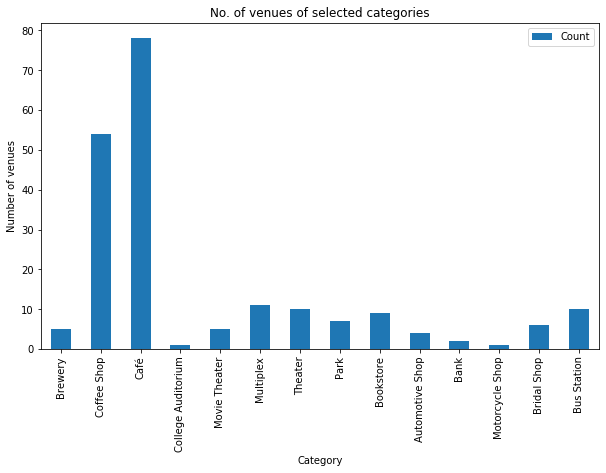

In [18]:
result.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('No. of venues of selected categories') # add title to the plot

plt.show()

## Grouping by Neighborhood

In [19]:
mumbai_venues.groupby(["Neighborhood"]).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agripada,5,5,5,5,5,5
Altamount Road,10,10,10,10,10,10
Amboli,7,7,7,7,7,7
Amrut Nagar,38,38,38,38,38,38
Asalfa,4,4,4,4,4,4
Ballard Estate,6,6,6,6,6,6
Bandstand Promenade,15,15,15,15,15,15
Bangur Nagar,4,4,4,4,4,4
Bhandup,11,11,11,11,11,11


In [20]:
print('There are {} uniques categories.'.format(len(mumbai_venues['Venue Category'].unique())))

There are 172 uniques categories.


## One Hot Encoding

In [21]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Neighborhoods'] = mumbai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]
print(mumbai_onehot.shape)
mumbai_onehot.head()

(1338, 173)


,Neighborhoods,ATM,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Line,Bus Station,Cafeteria,Café,Campground,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lake,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Mughlai Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Tea Room,Tennis Court,Tex-Mex Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Extracting the relevant columns 
This will indicate the competition in the neighborhoods and also help in selecting a neighborhood which has favorable venues
Like bookstore and college campuses because a coffee shop near these venues will be more profitable

In [22]:
mumbai_coffee=mumbai_onehot[['Neighborhoods','Bookstore','Brewery','Café','Coffee Shop','College Auditorium','Movie Theater','Multiplex','Park','Theater','Automotive Shop','Bank','Motorcycle Shop','Bridal Shop','Bus Station']]
mumbai_coffee.rename(columns={'Neighborhoods':'Neighborhood'},inplace=True)
mumbai_coffee.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Bookstore,Brewery,Café,Coffee Shop,College Auditorium,Movie Theater,Multiplex,Park,Theater,Automotive Shop,Bank,Motorcycle Shop,Bridal Shop,Bus Station
0,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Venues like cafes, brewery and coffee shop will act as our competition which means we need to set up our shop where there are less existing coffee shops.
People visiting bookstores, theaters,shops,banks are more likely to grab a cup of coffee.  So setting up a coffee shop in a neighbourhood where these venues are located would be favorable.

In [23]:
coffee_sum=mumbai_coffee['Brewery']+mumbai_coffee['Café']+mumbai_coffee['Coffee Shop']
select_venues=mumbai_coffee['Bookstore']+mumbai_coffee['College Auditorium']+mumbai_coffee['Movie Theater']+mumbai_coffee['Multiplex']+mumbai_coffee['Park']+mumbai_coffee['Theater']+mumbai_coffee['Automotive Shop']+mumbai_coffee['Bank']+mumbai_coffee['Motorcycle Shop']+mumbai_coffee['Bridal Shop']+mumbai_coffee['Bus Station']
mumbai_coffee['Competition']=coffee_sum
mumbai_coffee['Favourable Venues']=select_venues             

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Cleaning the data

In [24]:
mumbai_coffee.drop(['Bookstore'],axis=1,inplace=True)
mumbai_coffee.drop(['Brewery'],axis=1,inplace=True)
mumbai_coffee.drop(['Café'],axis=1,inplace=True)
mumbai_coffee.drop(['Coffee Shop'],axis=1,inplace=True)
mumbai_coffee.drop(['College Auditorium'],axis=1,inplace=True)
mumbai_coffee.drop(['Movie Theater'],axis=1,inplace=True)
mumbai_coffee.drop(['Multiplex'],axis=1,inplace=True)
mumbai_coffee.drop(['Park'],axis=1,inplace=True)
mumbai_coffee.drop(['Theater'],axis=1,inplace=True)
mumbai_coffee.drop(['Automotive Shop'],axis=1,inplace=True)
mumbai_coffee.drop(['Bank'],axis=1,inplace=True)
mumbai_coffee.drop(['Motorcycle Shop'],axis=1,inplace=True)
mumbai_coffee.drop(['Bridal Shop'],axis=1,inplace=True)
mumbai_coffee.drop(['Bus Station'],axis=1,inplace=True)
mumbai_coffee.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Competition,Favourable Venues
0,Amboli,0,0
1,Amboli,0,0
2,Amboli,0,0
3,Amboli,1,0
4,Amboli,0,0


In [25]:
mumbai_grouped = mumbai_coffee.groupby(["Neighborhood"]).mean().reset_index()

print(mumbai_grouped.shape)
mumbai_grouped.head()

(84, 3)


,Neighborhood,Competition,Favourable Venues
0,Agripada,0.200000,0.000000
1,Altamount Road,0.300000,0.100000
2,Amboli,0.142857,0.000000
3,Amrut Nagar,0.157895,0.052632
4,Asalfa,0.000000,0.250000


## Clustering

In [26]:
kclusters = 3

mumbai_clustering = mumbai_grouped.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 1, 1, 0, 1, 1], dtype=int32)

In [27]:
mumbai_merged = mumbai_grouped.copy()

# add clustering labels
mumbai_merged["Cluster Labels"] = kmeans.labels_

In [28]:
mumbai_merged.head()

,Neighborhood,Competition,Favourable Venues,Cluster Labels
0,Agripada,0.200000,0.000000,0
1,Altamount Road,0.300000,0.100000,0
2,Amboli,0.142857,0.000000,0
3,Amrut Nagar,0.157895,0.052632,0
4,Asalfa,0.000000,0.250000,2


In [29]:
mumbai_merged = mumbai_merged.join(df.set_index("Neighborhood"), on="Neighborhood")

print(mumbai_merged.shape)
mumbai_merged.head() # check the last columns!

(84, 6)


,Neighborhood,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
0,Agripada,0.200000,0.000000,0,18.977700,72.827300
1,Altamount Road,0.300000,0.100000,0,18.968100,72.809500
2,Amboli,0.142857,0.000000,0,19.129300,72.843400
3,Amrut Nagar,0.157895,0.052632,0,19.102077,72.912835
4,Asalfa,0.000000,0.250000,2,19.091000,72.901000


## Plotting the clusters on the map of Mumbai

In [30]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Neighborhood'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the clusters

## Cluster 0

In [31]:
mumbai_label0=mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0]
mumbai_label0                                

,Neighborhood,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
0,Agripada,0.200000,0.000000,0,18.977700,72.827300
1,Altamount Road,0.300000,0.100000,0,18.968100,72.809500
2,Amboli,0.142857,0.000000,0,19.129300,72.843400
3,Amrut Nagar,0.157895,0.052632,0,19.102077,72.912835
7,Bangur Nagar,0.250000,0.000000,0,19.167362,72.832252
11,Breach Candy,0.200000,0.085714,0,18.967000,72.805000
12,C.G.S. colony,0.166667,0.000000,0,19.016378,72.856629
14,Cavel,0.157895,0.105263,0,18.947400,72.827200
17,Charkop,0.200000,0.000000,0,19.216182,72.830575
19,Chira Bazaar,0.166667,0.000000,0,18.948140,72.825462


In [32]:
mumbai_label0.describe()

,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
count,26.000000,26.000000,26.0,26.000000,26.000000
mean,0.222369,0.036917,0.0,19.038633,72.836689
std,0.086259,0.050583,0.0,0.095354,0.035058
min,0.142857,0.000000,0.0,18.944700,72.795000
25%,0.160088,0.000000,0.0,18.963633,72.811532
50%,0.200000,0.000000,0.0,19.005828,72.829750
75%,0.250000,0.077444,0.0,19.122308,72.844422
max,0.500000,0.142857,0.0,19.250069,72.930000


## Cluster 1

In [33]:
mumbai_label1=mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1]
mumbai_label1

,Neighborhood,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
5,Ballard Estate,0.000000,0.000000,1,18.950000,72.840000
6,Bandstand Promenade,0.066667,0.000000,1,19.042718,72.819132
8,Bhandup,0.090909,0.090909,1,19.140000,72.930000
9,Bhayandar,0.000000,0.000000,1,19.290000,72.850000
10,Bhuleshwar,0.000000,0.000000,1,18.950000,72.830000
13,Carmichael Road,0.058824,0.000000,1,18.972200,72.811300
15,"Chakala\tAndheri,",0.111111,0.111111,1,19.111388,72.860833
16,Chandivali,0.000000,0.090909,1,19.110000,72.900000
18,Chembur,0.066667,0.000000,1,19.051000,72.894000
20,Chor Bazaar,0.000000,0.000000,1,18.960321,72.827176


In [34]:
mumbai_label1.describe()

,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
count,51.000000,51.000000,51.0,51.000000,51.000000
mean,0.050095,0.030369,1.0,19.080621,72.850143
std,0.046063,0.041859,0.0,0.106099,0.036595
min,0.000000,0.000000,1.0,18.910000,72.782021
25%,0.000000,0.000000,1.0,18.988104,72.828866
50%,0.064516,0.000000,1.0,19.080000,72.840000
75%,0.083333,0.060662,1.0,19.127764,72.862862
max,0.125000,0.129032,1.0,19.351467,72.970000


## Cluster 2

In [35]:
mumbai_label2=mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2]
mumbai_label2

,Neighborhood,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
4,Asalfa,0.0,0.250000,2,19.091000,72.901000
34,Dongri,0.0,0.166667,2,19.283333,72.783333
35,Fanas Wadi,0.0,0.250000,2,18.951811,72.825309
47,Kanjurmarg,0.0,0.333333,2,19.130000,72.940000
62,Mumbai Central,0.0,0.153846,2,18.969700,72.819400
65,Nalasopara,0.0,0.333333,2,19.415400,72.861300
78,Uttan,0.0,0.166667,2,19.280000,72.785000


In [36]:
mumbai_label2.describe()

,Competition,Favourable Venues,Cluster Labels,Latitude,Longitude
count,7.0,7.000000,7.0,7.000000,7.000000
mean,0.0,0.236264,2.0,19.160178,72.845049
std,0.0,0.077139,0.0,0.173233,0.058981
min,0.0,0.153846,2.0,18.951811,72.783333
25%,0.0,0.166667,2.0,19.030350,72.802200
50%,0.0,0.250000,2.0,19.130000,72.825309
75%,0.0,0.291667,2.0,19.281667,72.881150
max,0.0,0.333333,2.0,19.415400,72.940000


## Results

On examining the three clusters these observations can be made-
1. Neighborhoods of Cluster 0 has average competition 0.22 and favorable venues 0.03
2. Neighborhoods of Cluster 1 has average competition 0.05 and favorable venues 0.03
3. Neighborhoods of Cluster 2 has average competition 0.00 and favorable venues 0.23

## Discussions

Mumbai is the financial, commercial and entertainment capital of India which makes it the perfect choice for setting up a coffee shop business.It's immense population is a plus point. Through this project I have tried to examine some factors that can affect the coffee shop business. A location having less competition and more venues to attract people to the shop would be the ideal spot.

## Conclusion

<em>Cluster 2 seems to have a negligible competition and fair amount of favorable venues to bring people to the coffee shop. So a preferred neighborhood to set up a coffee shop would be one present in Cluster 2.</em>